In [1]:
import numpy as np
import statsmodels.api as sm
import scipy as sp
import scipy.special
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# sigmoid function
def sigmoid(x):
    return (1/(1 + np.exp(-x)))

# weight dot independent variables 
def pro(w, x):
    return sigmoid(np.inner(w, x))

# first coefficient in beta prior
def alpha(p, phi):
    return (((1 / phi) - 1) * p)

# second coefficient in beta prior
def beta(p, phi):
    return (((1 / phi) - 1) * (1 - p))

# average cost of beta-binomial regression excluding constant 
def cost(f, exog, endog):
    cos = 0
    for n in range(len(exog)):
        p = pro(f[:-1], exog[n])
        a = alpha(p, f[-1])
        b = beta(p, f[-1])
        cos += sp.special.betaln(endog[n][0] + a, endog[n][1] + b) - sp.special.betaln(a, b)
    return - cos / len(exog)

# predict the output given the parametres
def predict(f, exog, endog):
    p_pred = sigmoid(np.matmul(exog, f[:-1]))
    return np.concatenate(([p_pred * (endog[:, 0] + endog[:, 1])], [(1 - p_pred) * (endog[:, 0] + endog[:, 1])]), axis = 0).T 

# log-likelihood of the data
def LL(f, exog, endog):
    return - cost(f, exog, endog) * len(exog) + sum(sp.special.gammaln(endog[:,0] + endog[:,1] + 1) - sp.special.gammaln(endog[:,0] + 1) - sp.special.gammaln(endog[:,1] + 1))

# find the best initial guess for phi
def initial(params, exog, endog):
    guess = np.arange(0.99999, 10, 0.1)
    cos = [0]
    while np.argmin(cos) == 0:
        guess = guess / 10
        cos = []
        for m in range(len(guess)): 
            f = np.concatenate((params, [guess[m]]))
            cos.append(cost(f, exog, endog))
        if np.isnan(cos).any():
            print("bad result")
            break
    f = np.concatenate((params, [guess[np.argmin(cos)]]))
    # print("initial guess = ", f)
    # print("cost of initial guess =", cos[np.argmin(cos)])
    return f

# beta-binomial regression
def fit(self):
    glm_binom = sm.GLM(self.endog, self.exog, family = sm.families.Binomial())
    res = glm_binom.fit()
        
    bnds = []
    for m in range(len(res.params)):
        bnds.append((- np.inf, np.inf))
    bnds.append((0,1))
    bnds_t = tuple(bnds)
        
    f = initial(res.params, self.exog, self.endog)
    ress = sp.optimize.minimize(cost, f, args = (self.exog, self.endog), method = self.method, bounds = bnds_t)
    return ress.x

In [3]:
# can be any method scipy.optimize.minimize supports
class betabin:
    def __init__(self, exog, endog, fit_intercept = True, method = "SLSQP"):
        self.n_features_in_ = len(exog[0])
        self.intercept_ = fit_intercept
        if self.intercept_:
            exog = sm.add_constant(exog, prepend = False)
        self.exog = exog
        self.endog = endog
        self.method = method
        self.params = fit(self)
        self.predict = predict(self.params, self.exog, self.endog)
        self.LL = LL(self.params, self.exog, self.endog)
        # if self.LL > 0:
        #     raise Exception("Abnormal log-likelihood")

In [4]:
AD = sp.io.mmread("cellSNP.tag.AD.mtx")
DP = sp.io.mmread("cellSNP.tag.DP.mtx")

AD1 = np.asarray(AD.todense())
DP1 = np.asarray(DP.todense())

In [5]:
AD2 = []
SNPS = []
for i in range(len(AD1)):
    if AD1[i].all() == 0:
        continue
    elif (AD1[i].all() == DP1[i]).all():
        continue
    AD2.append(AD1[i])
    SNPS.append(i)

DP2 = []
for i in range(len(DP1)):
    if DP1[i].all() == 0:
        continue
    elif (DP1[i].all() == AD1[i]).all():
        continue
    elif AD1[i].all() == 0:
        continue
    DP2.append(DP1[i])

label = pd.read_csv('id.csv')
label1 = label.iloc[:,1].to_numpy()

clone0 = np.zeros(77) 
clone0[np.where(label1 == 0)] = 1
clone1 = np.zeros(77) 
clone1[np.where(label1 == 1)] = 1
clone2 = np.zeros(77) 
clone2[np.where(label1 == 2)] = 1

In [6]:
summ = []
for n in range(24):
    summ.append(np.sum(DP1[n]))
#summ

In [7]:
print("clone 0:", len(np.where(label1 == 0)[0]))
print("clone 1:",len(np.where(label1 == 1)[0]))
print("clone 2:",len(np.where(label1 == 2)[0]))

clone 0: 15
clone 1: 55
clone 2: 7


In [8]:
# all clones
all_LL = []
for SNP in range(len(AD2)):
    mask = np.where(DP2[SNP] != 0)
    endog = np.array([AD2[SNP][mask], DP2[SNP][mask] - AD2[SNP][mask]]).T
    exog = np.array([clone0[mask], clone1[mask]]).T
    model = betabin(exog, endog)
    all_LL.append(model.LL)
print(max(all_LL))
print(min(all_LL))
all_LL = np.array(all_LL)

<ipython-input-2-b8d8bb1f8de6>:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (((1 / phi) - 1) * p)
<ipython-input-2-b8d8bb1f8de6>:15: RuntimeWarning: divide by zero encountered in double_scalars
  return (((1 / phi) - 1) * (1 - p))
<ipython-input-2-b8d8bb1f8de6>:24: RuntimeWarning: invalid value encountered in double_scalars
  cos += sp.special.betaln(endog[n][0] + a, endog[n][1] + b) - sp.special.betaln(a, b)
<ipython-input-2-b8d8bb1f8de6>:3: RuntimeWarning: overflow encountered in exp
  return (1/(1 + np.exp(-x)))
<ipython-input-2-b8d8bb1f8de6>:11: RuntimeWarning: invalid value encountered in double_scalars
  return (((1 / phi) - 1) * p)


-9.468078830151228
-56.43064780910987


In [9]:
# clone 0 only
clone0_LL = []
for SNP in range(len(AD2)):
    mask = np.where(DP2[SNP] != 0)
    endog = np.array([AD2[SNP][mask], DP2[SNP][mask] - AD2[SNP][mask]]).T
    exog = np.array([clone0[mask]]).T
    model = betabin(exog, endog)
    clone0_LL.append(model.LL)
print(max(clone0_LL))
print(min(clone0_LL))
clone0_LL = np.array(clone0_LL)

<ipython-input-2-b8d8bb1f8de6>:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (((1 / phi) - 1) * p)
<ipython-input-2-b8d8bb1f8de6>:15: RuntimeWarning: divide by zero encountered in double_scalars
  return (((1 / phi) - 1) * (1 - p))
<ipython-input-2-b8d8bb1f8de6>:24: RuntimeWarning: invalid value encountered in double_scalars
  cos += sp.special.betaln(endog[n][0] + a, endog[n][1] + b) - sp.special.betaln(a, b)
<ipython-input-2-b8d8bb1f8de6>:15: RuntimeWarning: invalid value encountered in double_scalars
  return (((1 / phi) - 1) * (1 - p))


3049.694246906391
-56.430773859027624


In [10]:
# clone 1 only
clone1_LL = []
for SNP in range(len(AD2)):
    mask = np.where(DP2[SNP] != 0)
    endog = np.array([AD2[SNP][mask], DP2[SNP][mask] - AD2[SNP][mask]]).T
    exog = np.array([clone1[mask]]).T
    model = betabin(exog, endog)
    clone1_LL.append(model.LL)
print(max(clone1_LL))
print(min(clone1_LL))
clone1_LL = np.array(clone1_LL)

<ipython-input-2-b8d8bb1f8de6>:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (((1 / phi) - 1) * p)
<ipython-input-2-b8d8bb1f8de6>:15: RuntimeWarning: divide by zero encountered in double_scalars
  return (((1 / phi) - 1) * (1 - p))
<ipython-input-2-b8d8bb1f8de6>:3: RuntimeWarning: overflow encountered in exp
  return (1/(1 + np.exp(-x)))
<ipython-input-2-b8d8bb1f8de6>:11: RuntimeWarning: invalid value encountered in double_scalars
  return (((1 / phi) - 1) * p)
<ipython-input-2-b8d8bb1f8de6>:24: RuntimeWarning: invalid value encountered in double_scalars
  cos += sp.special.betaln(endog[n][0] + a, endog[n][1] + b) - sp.special.betaln(a, b)


-9.854233897406687
-8601.861399961412


In [11]:
# clone 2 only
# abnormal log-likelihood on one SNP, should be a bug in the log-likelihood function
clone2_LL = []
for SNP in range(len(AD2)):
    mask = np.where(DP2[SNP] != 0)
    endog = np.array([AD2[SNP][mask], DP2[SNP][mask] - AD2[SNP][mask]]).T
    exog = np.array([clone2[mask]]).T
    model = betabin(exog, endog)
    clone2_LL.append(model.LL)
print(max(clone2_LL))
print(min(clone2_LL))
clone2_LL = np.array(clone2_LL)

<ipython-input-2-b8d8bb1f8de6>:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (((1 / phi) - 1) * p)
<ipython-input-2-b8d8bb1f8de6>:15: RuntimeWarning: divide by zero encountered in double_scalars
  return (((1 / phi) - 1) * (1 - p))
<ipython-input-2-b8d8bb1f8de6>:24: RuntimeWarning: invalid value encountered in double_scalars
  cos += sp.special.betaln(endog[n][0] + a, endog[n][1] + b) - sp.special.betaln(a, b)


163868.41893828494
-56.69891721140988


In [12]:
# no clones
nil_LL = []
for SNP in range(len(AD2)):
    mask = np.where(DP2[SNP] != 0)
    endog = np.array([AD2[SNP][mask], DP2[SNP][mask] - AD2[SNP][mask]]).T
    exog = np.array([np.ones(len(mask[0]))]).T
    model = betabin(exog, endog, fit_intercept = False)
    nil_LL.append(model.LL)
print(max(nil_LL))
print(min(nil_LL))
nil_LL = np.array(nil_LL)

<ipython-input-2-b8d8bb1f8de6>:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (((1 / phi) - 1) * p)
<ipython-input-2-b8d8bb1f8de6>:15: RuntimeWarning: divide by zero encountered in double_scalars
  return (((1 / phi) - 1) * (1 - p))


-9.808389317640433
-56.70846130537794


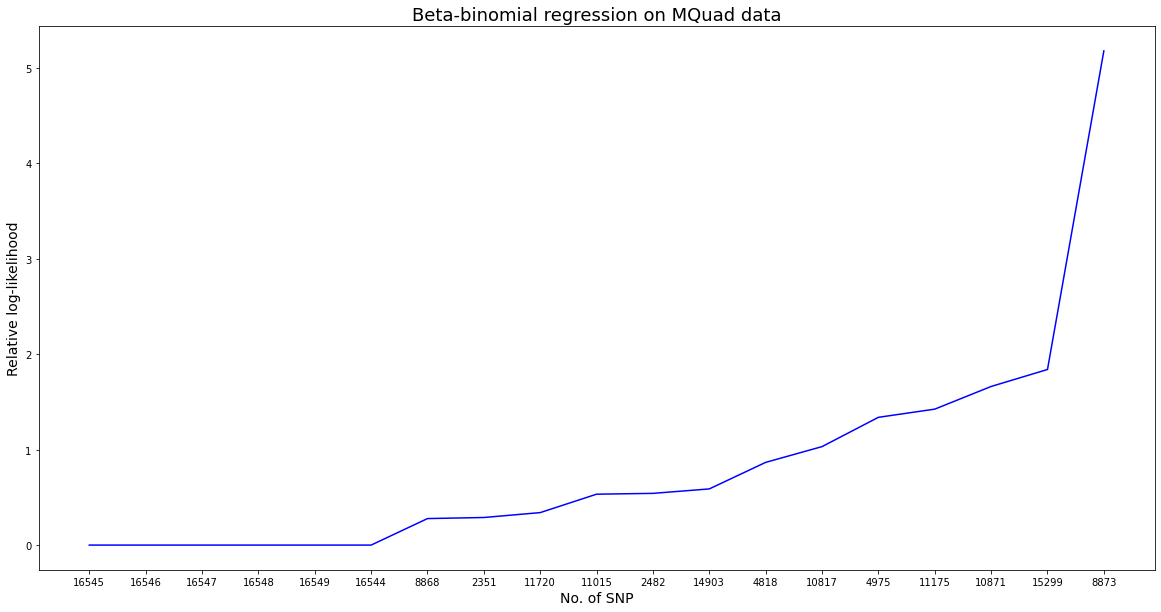

In [13]:
fig, ax1 = plt.subplots(figsize = (20, 10))

yValues = np.zeros(len(AD1)-14)
temp = all_LL-nil_LL
yValues = np.concatenate((yValues, temp))
SNPS = np.concatenate((np.arange(len(yValues)-len(SNPS)), SNPS))
yValues = yValues[-20:-1]
SNPS = SNPS[-20:-1]
xValues = np.arange(len(SNPS))

for i in range(len(yValues)):
    for j in range(len(yValues)):
        if yValues[i] < yValues[j]:
            temp = yValues[i]
            yValues[i] = yValues[j]
            yValues[j] = temp
            temp2 = SNPS[i]
            SNPS[i] = SNPS[j]
            SNPS[j] = temp2
        elif yValues[i] == 0:
            continue
SNPS.astype('str')

plt.plot(xValues, yValues, color ='b', zorder=5, label='All clones')
ax1.set_xticks(xValues)
ax1.set_xticklabels(SNPS)
plt.title("Beta-binomial regression on MQuad data", fontsize=18)
plt.xlabel("No. of SNP", fontsize=14)
plt.ylabel("Relative log-likelihood", fontsize=14)
plt.savefig('betabin.png')
plt.show()